In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data visualization

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix, coo_matrix

In [3]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv')
#df = pd.read_csv('/Users/lecueguillaume/Documents/bnpp/bnpp_donnees/ETSAnonymousPricesFull.csv')

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
nb_customers = len(set(df['Customer']))
nb_tickers = len(set(df['Ticker']))
row_idx = {tck: i for i, tck in enumerate(set(df['Ticker']))}

In [5]:
df['TradeDate'] = pd.to_datetime(df['TradeDate'], format='%Y%m%d')  # Transform date into real dates

In [6]:
ddata = df.ix[df["BuySell"] == "Buy", [u'Customer', u'NotionalEUR', u'Ticker', u'TradeDate']]

In [7]:
ddata.head()

,Customer,NotionalEUR,Ticker,TradeDate
1,36,50000.000000,NDB,2014-10-02
2,203,1500000.000000,REPSM,2014-02-03
4,2,789016.884961,BACR,2014-10-02
6,2,789016.884961,ACAFP,2014-10-02
8,203,1000000.000000,EVKGR,2014-02-03


# Preprocessing

In [35]:
cut_date = pd.to_datetime('20131106', format='%Y%m%d')

data_train = pd.DataFrame.copy(ddata)
data_train.ix[data_train[u'TradeDate'] <= cut_date, "NotionalEUR"] = 0

data_test = pd.DataFrame.copy(ddata)
data_test.ix[data_test[u'TradeDate'] > cut_date, "NotionalEUR"] = 0

print "#train = %s" % (data_train["NotionalEUR"] != 0).sum()
print "#test = %s" % (data_test["NotionalEUR"] != 0).sum()

#train = 397961
#test = 147079


In [79]:
cut_count = 10
n_bins = 4
labels = range(1, n_bins + 1)

train_dense = data_train.groupby(['Customer', 'Ticker'])
train_dense = train_dense['NotionalEUR'].agg({'NotionalSum' : np.sum, 'count' : 'count'}).reset_index()
train_dense = train_dense.groupby('Customer').filter(lambda x: sum(x['count']) >= cut_count)
train_dense[u'NotionalRating'], bins = pd.qcut(train_dense[u'NotionalSum'], n_bins, labels=labels, retbins=True)
# train_dense[u'NotionalRating'] = train_dense[u'NotionalSum']  # See `Another kind of pre-processing`

test_dense = data_test.groupby(['Customer', 'Ticker'])
test_dense = test_dense['NotionalEUR'].agg({'NotionalSum' : np.sum, 'count' : 'count'}).reset_index()
test_dense = test_dense.groupby('Customer').filter(lambda x: sum(x['count']) >= cut_count)
test_dense[u'NotionalRating'] = pd.cut(test_dense[u'NotionalSum'], bins, labels=labels)
# test_dense[u'NotionalRating'] = test_dense[u'NotionalSum']

train_dense['Ticker'] = train_dense['Ticker'].map(lambda x: row_idx[x])
test_dense['Ticker'] = test_dense['Ticker'].map(lambda x: row_idx[x])

train_dense.drop(['count', 'NotionalSum'], axis=1, inplace=True)
test_dense.drop(['count', 'NotionalSum'], axis=1, inplace=True)

In [80]:
idx = ~np.isnan(np.array(train_dense['NotionalRating']))
train_dense = train_dense[idx]
idx = ~np.isnan(np.array(test_dense['NotionalRating']))
test_dense = test_dense[idx]

In [81]:
train_dense.head()

,Customer,Ticker,NotionalRating
0,1,859,3
1,1,662,4
2,1,658,2
3,1,521,4
4,1,1220,2


In [82]:
data = train_dense['NotionalRating']
row = train_dense['Customer']
col = train_dense['Ticker']
train_coo = coo_matrix((data, (row, col)), shape=(nb_customers, nb_tickers))
train_coo

<2030x1258 sparse matrix of type '<type 'numpy.int64'>'
	with 103269 stored elements in COOrdinate format>

In [83]:
data = test_dense['NotionalRating']
row = test_dense['Customer']
col = test_dense['Ticker']
test_coo = coo_matrix((data, (row, col)), shape=(nb_customers, nb_tickers))
test_coo

<2030x1258 sparse matrix of type '<type 'numpy.int64'>'
	with 42770 stored elements in COOrdinate format>

In [85]:
td_train = np.array(train_coo.todense())
td_test = np.array(test_coo.todense())

# Cap all to 1
td_train[td_train > 0] = 1
td_test[td_test > 0] = 1

# Normalize
# td_train /= np.sum(td_train, axis=1)[:, np.newaxis]
# td_train[np.isnan(td_train)] = 0
# td_test /= np.sum(td_test, axis=1)[:, np.newaxis]
# td_test[np.isnan(td_test)] = 0

<matplotlib.colorbar.Colorbar instance at 0x12fc5e1b8>

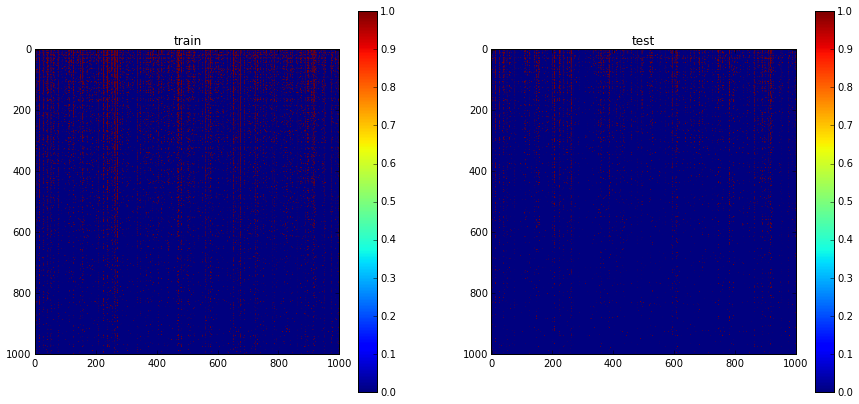

In [86]:
l = 1000

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.title("train")
plt.imshow(td_train[:l, :l])
plt.colorbar()

plt.subplot(2,2,2)
plt.title("test")
plt.imshow(td_test[:l, :l])
plt.colorbar()

<Container object of 3 artists>

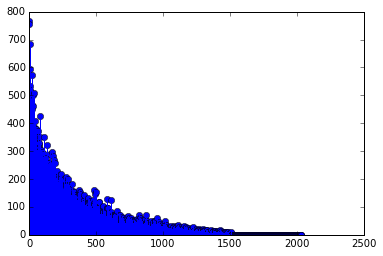

In [87]:
plt.stem(np.sum(td_train, axis=1))

In [88]:
td_train.shape

(2030, 1258)

In [89]:
td_train = np.array(td_train)
td_test = np.array(td_test)

td_train[np.isnan(td_train)] = 0
td_test[np.isnan(td_test)] = 0

In [90]:
# plt.hist(td_train[(td_train > 0) & (td_train < .05)], bins=100)
# plt.show()

In [91]:
# plt.hist(td_test[(td_test > 0) & (td_test < .05)], bins=100)
# plt.show()

In [92]:
# td_train[(td_train > .02) & (td_train < .08)] = 0.
# td_test[(td_test > 0.02) & (td_test < .08)] = 0.

# Client/Ticker representation

## Using matrix factorization

In [93]:
import nimfa
from timeit import default_timer as timer

In [94]:
# Using dense matrices currently as they fit in memory 
# and are faster to train for an unknown reason.
# def factorization_se(rank, n_trials=5):
#     average_se = 0.
#     for _ in range(n_trials):
#         model = nimfa.Nmf(td_train, seed='random_vcol', rank=rank, max_iter=100)
#         mfit = model()
#         M = np.array(mfit.coef())
#         N = np.array(mfit.basis())
#         NM = N.dot(M)
#         average_se += np.sqrt((np.array(NM - td_test)**2).sum())
#     print "rank = {}, se = {}".format(rank, average_se / float(n_trials))
#     return average_se / float(n_trials)

# rank_space = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
# se = []
# for rank in rank_space:
#     se.append(factorization_se(rank))

In [95]:
# plt.figure(figsize=(15, 5))
# plt.plot(rank_space, se)
# plt.show()

In [96]:
model = nimfa.Nmf(td_train, seed='random_vcol', rank=10, max_iter=100)
mfit = model()

M = np.array(mfit.coef())
N = np.array(mfit.basis())

print nb_customers, nb_tickers
print M.shape
print N.shape

2030 1258
(10, 1258)
(2030, 10)


In [97]:
# NM = np.array(N.dot(M).todense())
NM = N.dot(M)

<matplotlib.colorbar.Colorbar instance at 0x1836fb0e0>

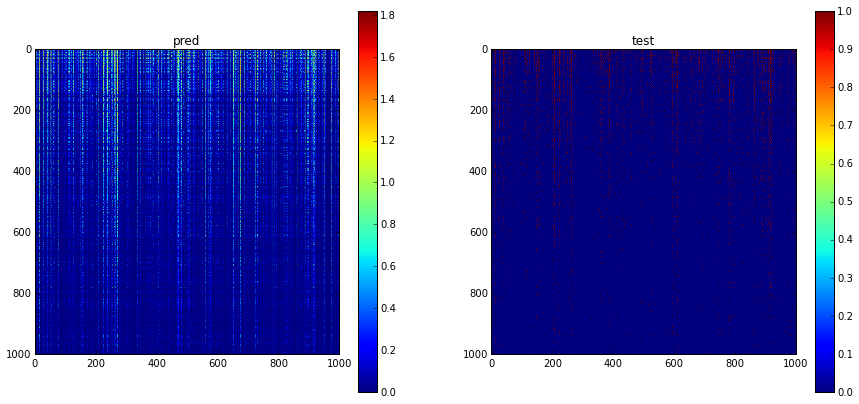

In [98]:
l = 1000

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.title("pred")
plt.imshow(NM[:l, :l])
plt.colorbar()

plt.subplot(2,2,2)
plt.title("test")
plt.imshow(td_test[:l, :l])
plt.colorbar()

In [99]:
se = np.sqrt((np.array(NM - td_test)**2).sum())
print('The square root error between the test set and the prediction is {}'.format(se))

The square root error between the test set and the prediction is 205.047887621


In [100]:
pred = NM[1:1323]
pred /= np.sum(pred, axis=1)[:, np.newaxis]

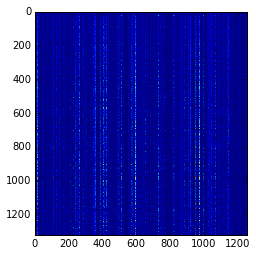

In [101]:
plt.imshow(pred)

## Clustering

In [102]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [103]:
## In the input space

In [104]:
pred = NM[1:1323]
pred /= np.sum(pred, axis=1)[:, np.newaxis]

In [196]:
# Clustering clients
print pred.shape

N_clusters = 100
# km = KMeans(N_clusters)
# km.fit(pred)
#yc = km.predict(pred)

yc = AgglomerativeClustering(N_clusters, affinity='cosine', linkage='average').fit_predict(pred)

(1322, 1258)


In [197]:
cc = np.array([sum(yc == i) for i in range(N_clusters)])
print('size of the clusters = {}'.format(list(cc)))

size of the clusters = [53, 16, 77, 32, 2, 16, 64, 17, 15, 22, 10, 59, 17, 12, 17, 8, 20, 6, 13, 7, 9, 20, 14, 35, 3, 9, 7, 9, 28, 2, 6, 14, 24, 6, 4, 5, 12, 5, 14, 5, 3, 13, 5, 31, 16, 13, 3, 8, 6, 3, 6, 4, 5, 20, 58, 7, 5, 5, 2, 1, 1, 1, 4, 8, 3, 34, 8, 3, 86, 13, 1, 7, 2, 1, 28, 4, 5, 3, 3, 4, 8, 1, 1, 2, 14, 5, 12, 3, 4, 3, 16, 1, 3, 21, 39, 17, 21, 1, 2, 1]


<Container object of 100 artists>

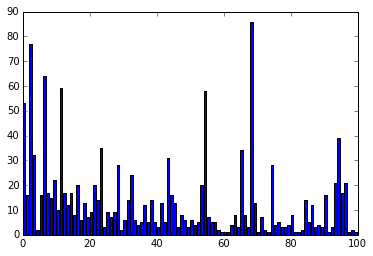

In [198]:
plt.bar(range(N_clusters), cc)

In [199]:
# Clustering tickers
print pred.T.shape

M_clusters = 50
# km = KMeans(M_clusters)
# km.fit(pred.T)
# yt = km.predict(pred.T)

yc = AgglomerativeClustering(N_clusters, affinity='cosine', linkage='average').fit_predict(pred.T)

(1258, 1322)


In [200]:
ct = np.array([sum(yt == i) for i in range(M_clusters)])
print('size of the clusters = {}'.format(list(ct)))

size of the clusters = [22, 6, 2, 407, 13, 7, 3, 118, 10, 16, 42, 7, 4, 4, 6, 32, 17, 8, 5, 75, 1, 5, 17, 20, 40, 9, 5, 22, 37, 11, 67, 5, 11, 2, 8, 4, 2, 4, 7, 23, 1, 41, 4, 1, 64, 18, 4, 3, 15, 3]


<Container object of 50 artists>

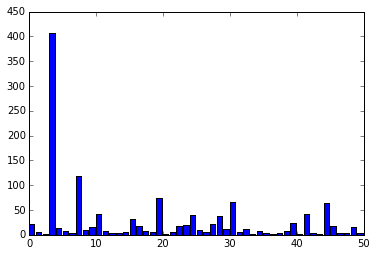

In [201]:
plt.bar(range(M_clusters), ct)

In [436]:
# Clustering tickers
print N.shape

N = N[1:1323]
N_normalized = N / np.sum(N, axis=1)[:, np.newaxis]
km_clients = KMeans(N_clusters)
km_clients.fit(N_normalized)

(2030, 10)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=100, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [437]:
YN = km_clients.predict(N_normalized)
csn = np.array([sum(YN == i) for i in range(N_clusters)])
print('size of the clients clusters = {}'.format(list(csn)))

size of the clients clusters = [15, 13, 11, 13, 14, 18, 21, 10, 29, 22, 28, 13, 9, 8, 9, 12, 15, 10, 21, 13, 9, 21, 17, 52, 14, 20, 14, 19, 8, 13, 13, 15, 13, 5, 23, 23, 7, 9, 6, 11, 12, 7, 12, 11, 10, 10, 13, 10, 11, 11, 16, 11, 13, 10, 18, 10, 20, 7, 25, 12, 20, 20, 8, 13, 10, 8, 11, 12, 13, 19, 23, 7, 5, 14, 11, 9, 17, 9, 8, 9, 6, 9, 13, 10, 10, 6, 4, 21, 12, 14, 11, 10, 11, 4, 17, 8, 2, 10, 14, 19]


<Container object of 100 artists>

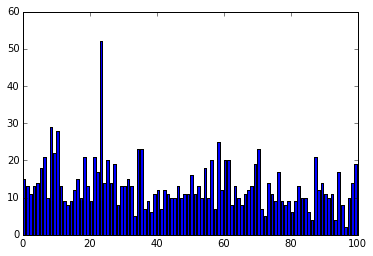

In [438]:
plt.bar(range(N_clusters), csn)

In [205]:
# Clustering tickers
print M.T.shape

M_normalized = M.T / np.sum(M.T, axis=1)[:, np.newaxis]
km_tickers = KMeans(M_clusters)
km_tickers.fit(M_normalized)

(1258, 10)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=50, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [206]:
YM = km_tickers.predict(M.T)
csm = np.array([sum(YM == i) for i in range(M_clusters)])
print('size of the bonds clusters = {}'.format(list(csm)))

size of the bonds clusters = [32, 44, 2, 45, 38, 3, 0, 405, 3, 12, 14, 44, 35, 13, 10, 19, 53, 6, 18, 15, 31, 11, 13, 11, 26, 11, 17, 37, 3, 18, 11, 11, 4, 22, 13, 36, 7, 3, 16, 12, 10, 18, 17, 6, 8, 18, 15, 12, 10, 20]


<Container object of 50 artists>

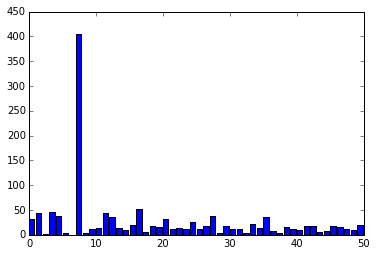

In [207]:
plt.bar(range(M_clusters), csm)

## Visualisation: t-SNE (or PCA)

In [208]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [209]:
T1 = reduced_data = PCA(n_components=2).fit_transform(pred)
T2 = reduced_data = PCA(n_components=2).fit_transform(pred.T)

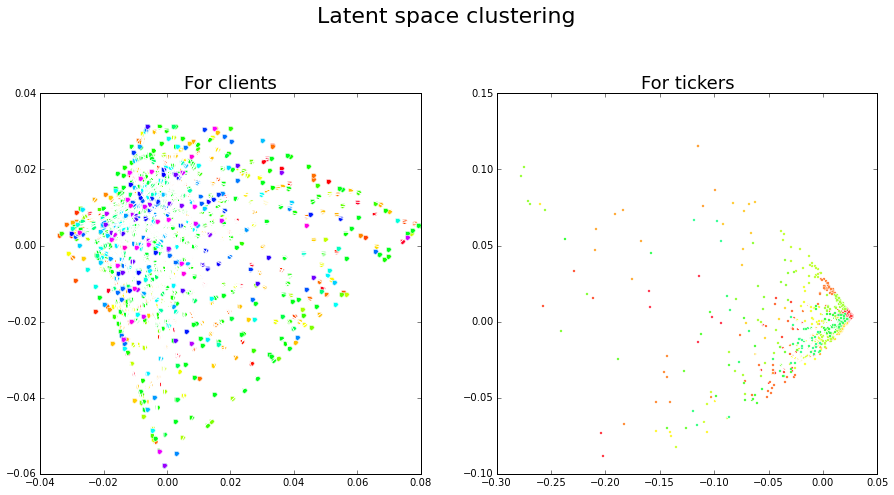

In [210]:
NUM_COLORS = max(N_clusters, M_clusters)

cm = get_cmap('gist_rainbow')
colors = []
for i in range(NUM_COLORS):
    colors.append(cm(1.*i/NUM_COLORS))

plt.figure(figsize=(15, 15))
plt.suptitle("Latent space clustering", size=22)
plt.subplot(2, 2, 1)
for k, col in zip(range(N_clusters), colors):
    my_members = yc == k
    plt.plot(T1[my_members, 0], T1[my_members, 1], 'w',
            markerfacecolor=col, marker='.', ms=10)
plt.title("For clients", size=18)
plt.subplot(2, 2, 2)
for k, col in zip(range(M_clusters), colors):
    my_members = yt == k
    plt.plot(T2[my_members, 0], T2[my_members, 1], 'w',
            markerfacecolor=col, marker='.', ms=5)
#     plt.axis((-2,2,-2,2))
plt.title("For tickers", size=18)
plt.show()

In [211]:
T1 = TSNE(n_components=2, random_state=0).fit_transform(pred)
T2 = TSNE(n_components=2, random_state=0).fit_transform(pred.T)

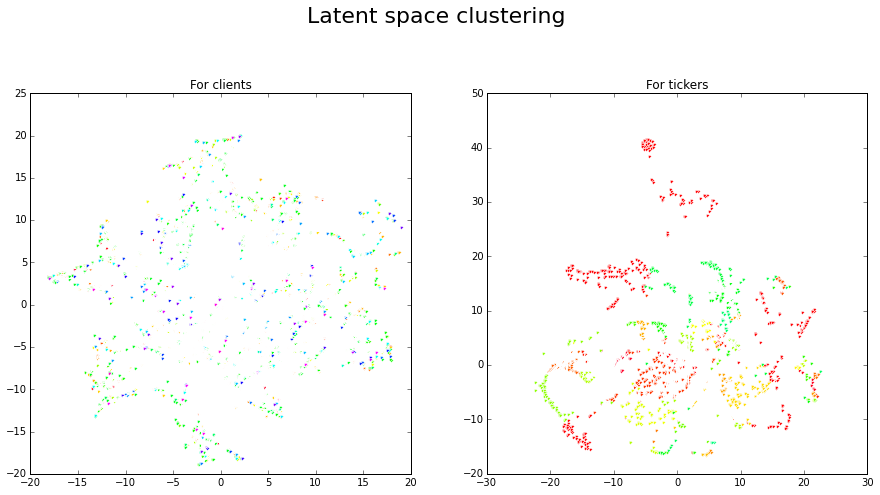

In [212]:
NUM_COLORS = max(N_clusters, M_clusters)

cm = get_cmap('gist_rainbow')
colors = []
for i in range(NUM_COLORS):
    colors.append(cm(1.*i/NUM_COLORS))

plt.figure(figsize=(15, 15))
plt.suptitle("Latent space clustering", size=22)
plt.subplot(2, 2, 1)
for k, col in zip(range(N_clusters), colors):
    my_members = yc == k
    plt.plot(T1[my_members, 0], T1[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
plt.title("For clients")
plt.subplot(2, 2, 2)
for k, col in zip(range(M_clusters), colors):
    my_members = yt == k
    plt.plot(T2[my_members, 0], T2[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
#     plt.axis((-2,2,-2,2))
plt.title("For tickers")
plt.show()

In [213]:
inverted_index = dict((ticker_id, ticker) for ticker, ticker_id in row_idx.iteritems())

In [214]:
for k in range(M_clusters):
    print 'cluster %s' % k,
    for ticker_id in np.array(range(nb_tickers))[yt == k]:
        print inverted_index[ticker_id], 
    print '\n'

cluster 0 CXGD CANARY BASQUE ONOSM ENGSM CAJARU CAIXAB KUTXAB PSGSM GALPPL MRDGF PTIPL AGROK CPFSM CASTIL ANTOLN JUNTEX REESM FERSM NAVARR ARAGON GESTAM 

cluster 1 EDF ABNANV NDASS DANBNK C AVLN 

cluster 2 TITIM TELEFO 

cluster 3 nan JAFZSK BMO NXPI LSTON DUBAIH EXANE NEDWBK RCOLIN AMLIN EMGLN CTRL BKNYML PGIM AZRAIL NOVAFR PERI MABLN FMEGR GM GLJGR HOUSF COFBBB FXPOLN REPNAM BREMLB SNTCSS VORHYP EVN DISCA TNEFT YBS CRBKMO ANGOL FOURSN EWOSAS BNAGRI FCCSM WMTRES SNSPW NACN K MARSLN GATESW SILVMA RPCUH TCOKZ DLR BNSELL BALEAR REPCON TTLINF FHYDRO KPERST DLGLN MANCHA JUTURN PMIPLC DISINT AVINOR HASTNS ALFASS RWANDA QIBKQD GGB SIBUR PHONLN AMSSM GULINT PEALLN JEF FREGR PREMI POSAV GOTVER SAMBNK VOYA CAIXAC ENEXIS HAVFP ERF ATFBP GIS VOYCAR UBMLN RUSB SHGFIN EUROGT TNZNIA BRKCAP VIRGMN HELTOW NBHA PPG VESTNL BHH AFRLN YUKSEL MERSEY OSCHAD AGAFP NJGANO KZAPKZ SCEPFU FOSSM CWCLN MBPSFN SHARSK IRAQ MUMTAK DERB AON PORTIG GTOFP CODIS CONTLV KGFLN KAUP LMETEL WAMU UPMKYM KOKSRU STRAV BEKBBB 

In [215]:
np.where(np.max(ct) == ct)

(array([3]),)

In [421]:
## Gephi

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import itertools

In [423]:
X = M.T
model = AgglomerativeClustering(M_clusters, linkage="average", affinity="cosine")
yt = model.fit_predict(X)

ii = itertools.count(X.shape[0])
tree = [{'id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

from itertools import chain
nodes = set(chain.from_iterable([list(l) for l in model.children_]))

In [424]:
# Gephi
with open('gephi3.gdf', 'w') as f:
    f.write('nodedef> name VARCHAR, label VARCHAR, label2 VARCHAR, cluster DOUBLE\n')
    for node in nodes:
        leaf = ', , ,'
        if node in inverted_index.keys():
            leaf = ", {}, {}, {}".format(inverted_index[node], inverted_index[node], yt[node])
        f.write(str(node) + leaf + '\n')
    f.write('edgedef> node1 VARCHAR, node2 VARCHAR\n')
    for n in tree:
        f.write("{}, {}\n".format(n['id'], n['left']))
        f.write("{}, {}\n".format(n['id'], n['right']))

In [425]:
# Node.js
def print_tree(n_leaves, model, inverted_index={}):
    children = np.empty(n_leaves + model.children_.shape[0], dtype=object)
    
    for i in range(n_leaves):
        children[i] = []
    
    for j in range(model.children_.shape[0]):
        children[n_leaves + j] = list(model.children_[j])
    
    def _collapse_linear():
        for k in range(len(children)):
            if children[k] != []:
                l, r = tuple(children[k])                
                if l < n_leaves:
                    children[k].extend(children[r])
                    if r > n_leaves:
                        children[k].remove(r)
                        children[r] = []
                elif r < n_leaves:
                    children[k].extend(children[l])
                    if l > n_leaves:
                        children[k].remove(l)
                        children[l] = []
    
    def _dfs(node):
        name = inverted_index.get(node) or node
        js = "{\"name\": \"%s\", \"children\": [" % name
        cc = []
        if children[node] is not None:
            for c in children[node]:
                cc.append(_dfs(c))
            js += ", ".join(cc) 
        js += "]}"
        return js
    
    _collapse_linear()
    return _dfs(len(children) - 1)

In [426]:
import json

In [429]:
js = json.loads(print_tree(M.T.shape[0], model, inverted_index))
with open("treeM.json", 'w') as f:
    json.dump(js, f)

In [439]:
X = N
model = AgglomerativeClustering(M_clusters, linkage="average", affinity="cosine")
yt = model.fit_predict(X)

ii = itertools.count(X.shape[0])
tree = [{'id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

from itertools import chain
nodes = set(chain.from_iterable([list(l) for l in model.children_]))

In [440]:
js = json.loads(print_tree(pred.shape[0], model))
with open("treeN.json", 'w') as f:
    json.dump(js, f)